In [3]:
import pandas as pd
import datetime
import numpy as np
from sqlalchemy import create_engine
import pymysql
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from collections import OrderedDict
import boto3

/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
Using TensorFlow backend.


In [4]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    model.reset_states()
    # convert to array
    return [x for x in forecast[0, :]]

In [5]:
# inverse data transform on forecasts
def inverse_transform(series, forecast, scaler):
    # create array from forecast
    forecast = np.array(forecast)
    forecast = forecast.reshape(1, -1)

    # invert scaling
    inv_scale = np.exp(scaler.inverse_transform(forecast))
    inv_scale = inv_scale[0, :]

    return inv_scale

In [6]:
def extrapolate_timeslots(start_date, num_days=1):
    """Extrapolate the forecast dates and timeslots and return dataframe with forecast_dates and timeslots"""

    timeslots_per_day = 96
    forecast_dates = []
    timeslots = []

    for days in range(1, num_days + 1):
        forecast_dates = forecast_dates + [(start_date + datetime.timedelta(days=days)).date()] * timeslots_per_day
        timeslots = timeslots + list(range(1, timeslots_per_day + 1))

    dictionary = {
        "forecast_date": forecast_dates,
        "timeslot": timeslots
    }

    return pd.DataFrame.from_dict(dictionary)

In [7]:
db_host = "yieldmanagement.c2jaydssljuc.us-west-2.rds.amazonaws.com"
db_username = "ymdsmaster"
db_password = "YieLDMgMt36"
db_name = "yieldmanagement"
db_port = "6174"

conn = create_engine('mysql+pymysql://' + db_username + ':' + db_password + '@' + db_host + ':' + db_port + '/' + db_name, echo=False)

start_date = '2017-07-01'
end_date = '2017-12-31'
channel = 'ESPN'
network_number = "33"  # This is ESPN

In [8]:
query = (
    "SELECT network_label, start_time,start_date,household_impressions, timeslot FROM yieldmanagement.rentrak_impressions_old where start_date BETWEEN '" + start_date + "' AND '" + end_date +"'  ORDER BY network_label, start_time;")

series = pd.read_sql(query, con=conn)

#series.set_index(keys=['start_time'], drop=False, inplace=True)
series.reset_index()
series.set_index(keys=['start_date'],drop=False,inplace=True)
series.drop(['start_time','start_date'], axis=1, inplace=True)


In [9]:
print("series shape", series.shape) 
print("series columns", series.columns)
series.head()

('series shape', (3199920, 3))
('series columns', Index([u'network_label', u'household_impressions', u'timeslot'], dtype='object'))


,network_label,household_impressions,timeslot
start_date,,,
2017-07-01,A&E,63034,1
2017-07-01,A&E,58037,2
2017-07-01,A&E,52216,3
2017-07-01,A&E,50285,4
2017-07-01,A&E,48636,5


In [10]:
series1 = series.loc[series['network_label'].isin(['ESPN'])]
#series1 = series
num_channels=len(series1.network_label.unique())
print(num_channels)

1


In [11]:
series1.head()

,network_label,household_impressions,timeslot
start_date,,,
2017-07-01,ESPN,45365,1
2017-07-01,ESPN,43367,2
2017-07-01,ESPN,42509,3
2017-07-01,ESPN,39906,4
2017-07-01,ESPN,42388,5


In [12]:
series1['network_timeslot']=series1['network_label'].astype(str)+"_"+series1['timeslot'].astype(str)

/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
series1.head()
series1.shape

(17664, 4)

In [14]:
series1.drop(['network_label','timeslot'],axis=1,inplace=True)

/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [15]:
series1.head()

,household_impressions,network_timeslot
start_date,,
2017-07-01,45365,ESPN_1
2017-07-01,43367,ESPN_2
2017-07-01,42509,ESPN_3
2017-07-01,39906,ESPN_4
2017-07-01,42388,ESPN_5


In [16]:
#series1[series1['household_impressions']==0]['household_impressions']=1
#series1[series1['household_impressions']==1]

In [17]:
series1 = series1.pivot(columns='network_timeslot')

In [18]:
series1

household_impressions                                  \
network_timeslot                ESPN_1 ESPN_10 ESPN_11 ESPN_12 ESPN_13   
start_date                                                               
2017-07-01                       45365   37481   34878   32639   31807   
2017-07-02                      180097   67926   61358   55960   53280   
2017-07-03                       78902   41251   37737   35311   32617   
2017-07-04                       92381   44931   41112   38546   37221   
2017-07-05                       65659   38042   35712   33320   28387   
2017-07-06                       55148   32232   29912   27480   25154   
2017-07-07                       50932   31836   30199   27957   27471   
2017-07-08                       55319   38060   36329   33885   33008   
2017-07-09                       54052   43619   41639   37931   36648   
2017-07-10                       84194   39404   36447   33564   32962   
2017-07-11                      151174   69331   66878   63946   63000   
2017-07-12                       52200   33236   31154   28565   27902   
2017-07-13                       46937   33578   31123   28831   27212   
2017-07-14                       46403   32618   30820   28439   28065   
2017-07-15                       46710   36475   34436   32579   32102   
2017-07-16                       49728   38962   36756   35022   32051   
2017-07-17                       85413   40905   37697   35142   32531   
2017-07-18                       65106   32387   29783   27644   27186   
2017-07-19                       55924   35268   33417   31286   28050   
2017-07-20                       44567   29247   27413   25750   22097   
2017-07-21                       31393   27792   26240   24243   24152   
2017-07-22                       65059   39916   38110   36577   35663   
2017-07-23                       88671   63555   59456   55958   54468   
2017-07-24                       87278   42149   38600   36031   33431   
2017-07-25                       50264   31364   29254   26493   26121   
2017-07-26                       50190   31591   29433   27756   27894   
2017-07-27                       59862   30245   28853   26885   26506   
2017-07-28                       41052   35681   34272   32936   32114   
2017-07-29                       46833   35660   33601   30434   30214   
2017-07-30                       39924   41609   40002   37691   36833   
...                                ...     ...     ...     ...     ...   
2017-12-02                      170952   79194   74486   69681   61811   
2017-12-03                      122373   78347   74147   68284   65014   
2017-12-04                       67374   38625   38213   36305   35014   
2017-12-05                      470061  135493  124124  112598  104536   
2017-12-06                       57834   34884   34629   32853   31762   
2017-12-07                       80246   46166   45498   43921   43092   
2017-12-08                       50978   34507   34039   32818   28522   
2017-12-09                      119606   60324   56557   52393   49036   
2017-12-10                       71605   54695   53692   49953   48121   
2017-12-11                       56733   37296   37570   36215   33758   
2017-12-12                      381285  120828  108901   97364   88273   
2017-12-13                      100816   41877   39699   37008   35194   
2017-12-14                       86804   55651   55047   54015   55136   
2017-12-15                       51612   33559   31724   29508   29520   
2017-12-16                      104968   54410   51450   47400   45579   
2017-12-17                      138514   69636   65180   59706   58237   
2017-12-18                       71730   42697   41535   37463   35947   
2017-12-19                      286819   99134   89290   80039   72906   
2017-12-20                       83520   44465   41649   38215   34127   
2017-12-21                       85466   51503   48949   46410   40206   
2017-12-22           

In [19]:
n_lag = 60
n_seq = 10
n_test =15
time_slots = 16
print(time_slots)
data = series1.iloc[:,0:time_slots]
#data = series

16


In [20]:
data.head()

household_impressions                                  \
network_timeslot                ESPN_1 ESPN_10 ESPN_11 ESPN_12 ESPN_13   
start_date                                                               
2017-07-01                       45365   37481   34878   32639   31807   
2017-07-02                      180097   67926   61358   55960   53280   
2017-07-03                       78902   41251   37737   35311   32617   
2017-07-04                       92381   44931   41112   38546   37221   
2017-07-05                       65659   38042   35712   33320   28387   

                                                                          \
network_timeslot ESPN_14 ESPN_15 ESPN_16 ESPN_17 ESPN_18 ESPN_19  ESPN_2   
start_date                                                                 
2017-07-01         30102   28508   27552   27696   26994   26580   43367   
2017-07-02         48667   45295   42266   41488   39000   37310  182934   
2017-07-03         29583   27869   27458   27024   26175   24961   69084   
2017-07-04         34639   32901   30855   30851   29145   28232   78948   
2017-07-05         24537   22223   20255   18985   17161   16209   61542   

                                                  
network_timeslot ESPN_20 ESPN_21 ESPN_22 ESPN_23  
start_date                                        
2017-07-01         26363   27194   27617   28038  
2017-07-02         35800   36117   35267   34845  
2017-07-03         23758   23843   24924   25223  
2017-07-04         26950   27045   26538   26631  
2017-07-05         15230   17539   19063   20131

In [21]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [22]:
def prepare_data2(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    #raw_values = raw_values.reshape(len(raw_values),time_slots)
   
    # rescale values to -1, 1
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = np.log(raw_values)
    scaled_values = scaled_values.reshape(len(scaled_values), time_slots)
        
    # transform into supervised learning problem X, y010
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return  train, test


In [23]:
train, test = prepare_data2(data,n_test,n_lag,n_seq)

In [24]:
train

array([[ 10.72249616,  10.53158942,  10.45961154, ...,  10.28813752,
         10.31174875,  10.32898402],
       [ 12.10125087,  11.12617416,  11.02448084, ...,  10.32855919,
         10.34611998,  10.35885332],
       [ 11.27596186,  10.62743063,  10.53839632, ...,  10.50064682,
         10.44827973,  10.40532288],
       ..., 
       [ 11.56894657,  10.78746168,  10.71417329, ...,  10.13725448,
         10.07200595,  10.01027705],
       [ 11.6661357 ,  11.03450249,  10.96235366, ...,  10.23598762,
         10.23974548,  10.2622104 ],
       [ 12.38479189,  11.46396629,  11.38777032, ...,  10.18414501,
         10.15708271,  10.15397386]])

In [25]:
train.shape

(100, 1120)

In [26]:
print(test.shape)
slice = n_lag * time_slots

(15, 1120)


In [27]:
X_train, y_train = train[:,0:slice], train[:,slice:]
X_test, y_test = test[:,0:slice], test[:,slice:]

In [28]:
#X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
#X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])

In [29]:
print("X_train Shape: "+str(X_train.shape))
print("X_test Shape: "+str(X_test.shape))

X_train Shape: (100, 960)
X_test Shape: (15, 960)


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [68]:
rfr = RandomForestRegressor()
param_grid = {"n_estimators"      : [250,275,300,350,400],
            "max_features"      : [ "auto","log2","sqrt"],
            "min_samples_split" : [2,4,8,10,20]
            }
grid = GridSearchCV(rfr,param_grid,cv=2)


In [69]:
grid.fit(X_train,y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [250, 275, 300, 350, 400], 'max_features': ['auto', 'log2', 'sqrt'], 'min_samples_split': [2, 4, 8, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [70]:
y_pred  = grid.predict(X_test)

grid.best_params_

{'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 250}

In [83]:
grid.score(X_test,y_test)

0.20779982930648658

In [71]:
y_pred = np.exp(grid.predict(X_test))

In [72]:
np.exp(y_test)

array([[  50978.,   34507.,   34039., ...,   32457.,   30795.,   29843.],
       [ 119606.,   60324.,   56557., ...,   20214.,   19695.,   19032.],
       [  71605.,   54695.,   53692., ...,   33256.,   30176.,   28519.],
       ..., 
       [  83520.,   44465.,   41649., ...,   41343.,   39153.,   37508.],
       [  85466.,   51503.,   48949., ...,   60364.,   56516.,   55578.],
       [  92250.,   50777.,   47517., ...,   55443.,   51174.,   49672.]])

In [73]:
error_percent =(y_pred -np.exp(y_test))/np.exp(y_test)

In [74]:
error_percent.shape

(15, 160)

In [75]:
errors = error_percent.reshape(15*160)

In [76]:
errors.shape

(2400,)

In [77]:
errors

array([ 0.48264377,  0.2614598 ,  0.20921107, ..., -0.45139406,
       -0.41373421, -0.40161988])

In [78]:
np.min(errors)

-0.86243050469384019

In [79]:
np.max(errors)

1.2256679067427663

In [80]:
np.median(errors)

-0.043002555757927968

In [81]:
from matplotlib import pyplot as plt

(array([   7.,    1.,    3.,    6.,    5.,    0.,   11.,   31.,   32.,
          42.,   25.,   22.,   31.,   50.,   97.,  118.,  154.,  188.,
         200.,  276.,  220.,  138.,  125.,  116.,  118.,   77.,   77.,
          52.,   54.,   37.,   29.,   17.,   17.,    7.,    1.,    4.,
           1.,    1.,    3.,    3.,    0.,    1.,    0.,    1.,    0.,
           1.,    0.,    0.,    0.,    1.]),
 array([-0.8624305 , -0.82066854, -0.77890657, -0.7371446 , -0.69538263,
        -0.65362066, -0.6118587 , -0.57009673, -0.52833476, -0.48657279,
        -0.44481082, -0.40304885, -0.36128689, -0.31952492, -0.27776295,
        -0.23600098, -0.19423901, -0.15247704, -0.11071508, -0.06895311,
        -0.02719114,  0.01457083,  0.0563328 ,  0.09809476,  0.13985673,
         0.1816187 ,  0.22338067,  0.26514264,  0.30690461,  0.34866657,
         0.39042854,  0.43219051,  0.47395248,  0.51571445,  0.55747642,
         0.59923838,  0.64100035,  0.68276232,  0.72452429,  0.76628626,
         0.80804

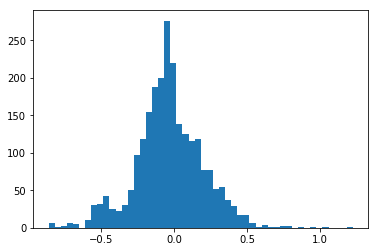

In [82]:
plt.hist(errors,50)

In [84]:
y_pred[-1,:]

array([  71165.40545784,   41613.0022793 ,   39628.12367791,
         37144.88814888,   34347.69747156,   31272.68775358,
         29376.53513331,   27681.75441756,   26742.77931441,
         25333.69579071,   24400.60232502,   64658.27105667,
         23855.50886136,   25386.59643855,   26004.06086208,
         27027.87077353,  103485.05802928,   54626.22655767,
         51264.90161402,   47816.32135533,   44690.17847608,
         40805.03750781,   38177.72602657,   35849.47519488,
         33472.13377204,   30819.82191659,   29116.85469336,
         93478.01127497,   27665.86327233,   27676.0473167 ,
         27326.54210683,   27442.43671295,  128951.44108977,
         70246.68231859,   66159.91958521,   62250.61190691,
         56712.48394328,   50904.3360354 ,   46245.5779865 ,
         40760.42447779,   37794.55215675,   35011.80117443,
         32900.34831208,  118371.68378902,   31284.38294443,
         31439.41858216,   31077.3718165 ,   31098.20859056,
         88088.44153095,

In [86]:
x = np.exp(y_test[-1,:])

In [87]:
x

array([  92250.,   50777.,   47517.,   44691.,   39546.,   35412.,
         32410.,   29877.,   28367.,   27147.,   25860.,   83728.,
         24605.,   27460.,   29543.,   31054.,  171923.,   74489.,
         68529.,   64240.,   57245.,   51187.,   46619.,   42769.,
         40461.,   37548.,   35554.,  165819.,   33700.,   32010.,
         30444.,   29471.,  105952.,   66336.,   62592.,   57669.,
         51935.,   45888.,   40523.,   37016.,   35003.,   33053.,
         31754.,  100245.,   30715.,   30066.,   29983.,   28582.,
        195689.,   60829.,   51603.,   46121.,   42484.,   39121.,
         36608.,   35353.,   32644.,   30357.,   28683.,  163366.,
         27567.,   28785.,   30050.,   33095.,  360417.,  106140.,
         94154.,   83707.,   76243.,   68984.,   63479.,   59667.,
         54107.,   48197.,   43639.,  286445.,   39349.,   36321.,
         33050.,   30805.,  275068.,   78381.,   72602.,   67260.,
         59553.,   52325.,   47156.,   42874.,   39844.,   365

In [88]:
x.shape

(160,)

In [89]:
y_pred.shape

(15, 160)

In [90]:
y_pred[-1,:].shape

(160,)

In [92]:
se = (y_pred[-1,:]-x)**2

In [98]:
rmse = np.mean(np.sqrt(se))

In [97]:
rmse

array([  21084.59454216,    9163.9977207 ,    7888.87632209,
          7546.11185112,    5198.30252844,    4139.31224642,
          3033.46486669,    2195.24558244,    1624.22068559,
          1813.30420929,    1459.39767498,   19069.72894333,
           749.49113864,    2073.40356145,    3538.93913792,
          4026.12922647,   68437.94197072,   19862.77344233,
         17264.09838598,   16423.67864467,   12554.82152392,
         10381.96249219,    8441.27397343,    6919.52480512,
          6988.86622796,    6728.17808341,    6437.14530664,
         72340.98872503,    6034.13672767,    4333.9526833 ,
          3117.45789317,    2028.56328705,   22999.44108977,
          3910.68231859,    3567.91958521,    4581.61190691,
          4777.48394328,    5016.3360354 ,    5722.5779865 ,
          3744.42447779,    2791.55215675,    1958.80117443,
          1146.34831208,   18126.68378902,     569.38294443,
          1373.41858216,    1094.3718165 ,    2516.20859056,
        107600.55846905,

In [109]:
rmse = np.sqrt(se)

{'boxes': [<matplotlib.lines.Line2D at 0x7f87053dd610>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8704850110>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8704850dd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8704850990>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f870b267810>,
  <matplotlib.lines.Line2D at 0x7f87053ddc90>]}

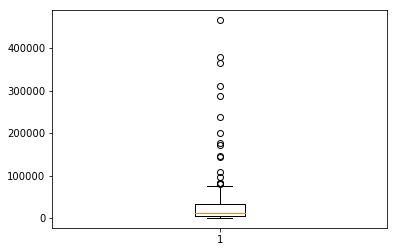

In [112]:
plt.boxplot(rmse)

In [113]:
np.min(rmse)

569.38294443409177

In [114]:
np.percentile(rmse,25)

4618.0949448607444

In [115]:
np.percentile(rmse,50)

12221.306690085632

In [116]:
np.percentile(rmse,75)

33235.218353486329

In [117]:
np.percentile(rmse,90)

75864.993655344297

In [118]:
np.percentile(rmse,95)

172851.2096549237

In [119]:
np.percentile(rmse,99)

370277.40285760746